In [12]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax


stock = pd.read_csv("../ALBRK.csv", parse_dates=['Date'], index_col='Date')
print(stock.head())


                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2010-01-01  1.196240  1.196240  1.196240  1.196240   1.023932         0
2010-01-04  1.190852  1.201629  1.190852  1.196240   1.023932    758454
2010-01-05  1.207017  1.260902  1.207017  1.244736   1.065443   9420657
2010-01-06  1.271679  1.293233  1.266290  1.282456   1.097730   7354184
2010-01-07  1.277067  1.314786  1.271679  1.309398   1.120791  12078601


In [13]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# Four weeks of lag features
y = stock.Close.copy()
X = make_lags(y, lags=4).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=8).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

In [14]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [15]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

Train RMSE: 0.06
Test RMSE: 0.14


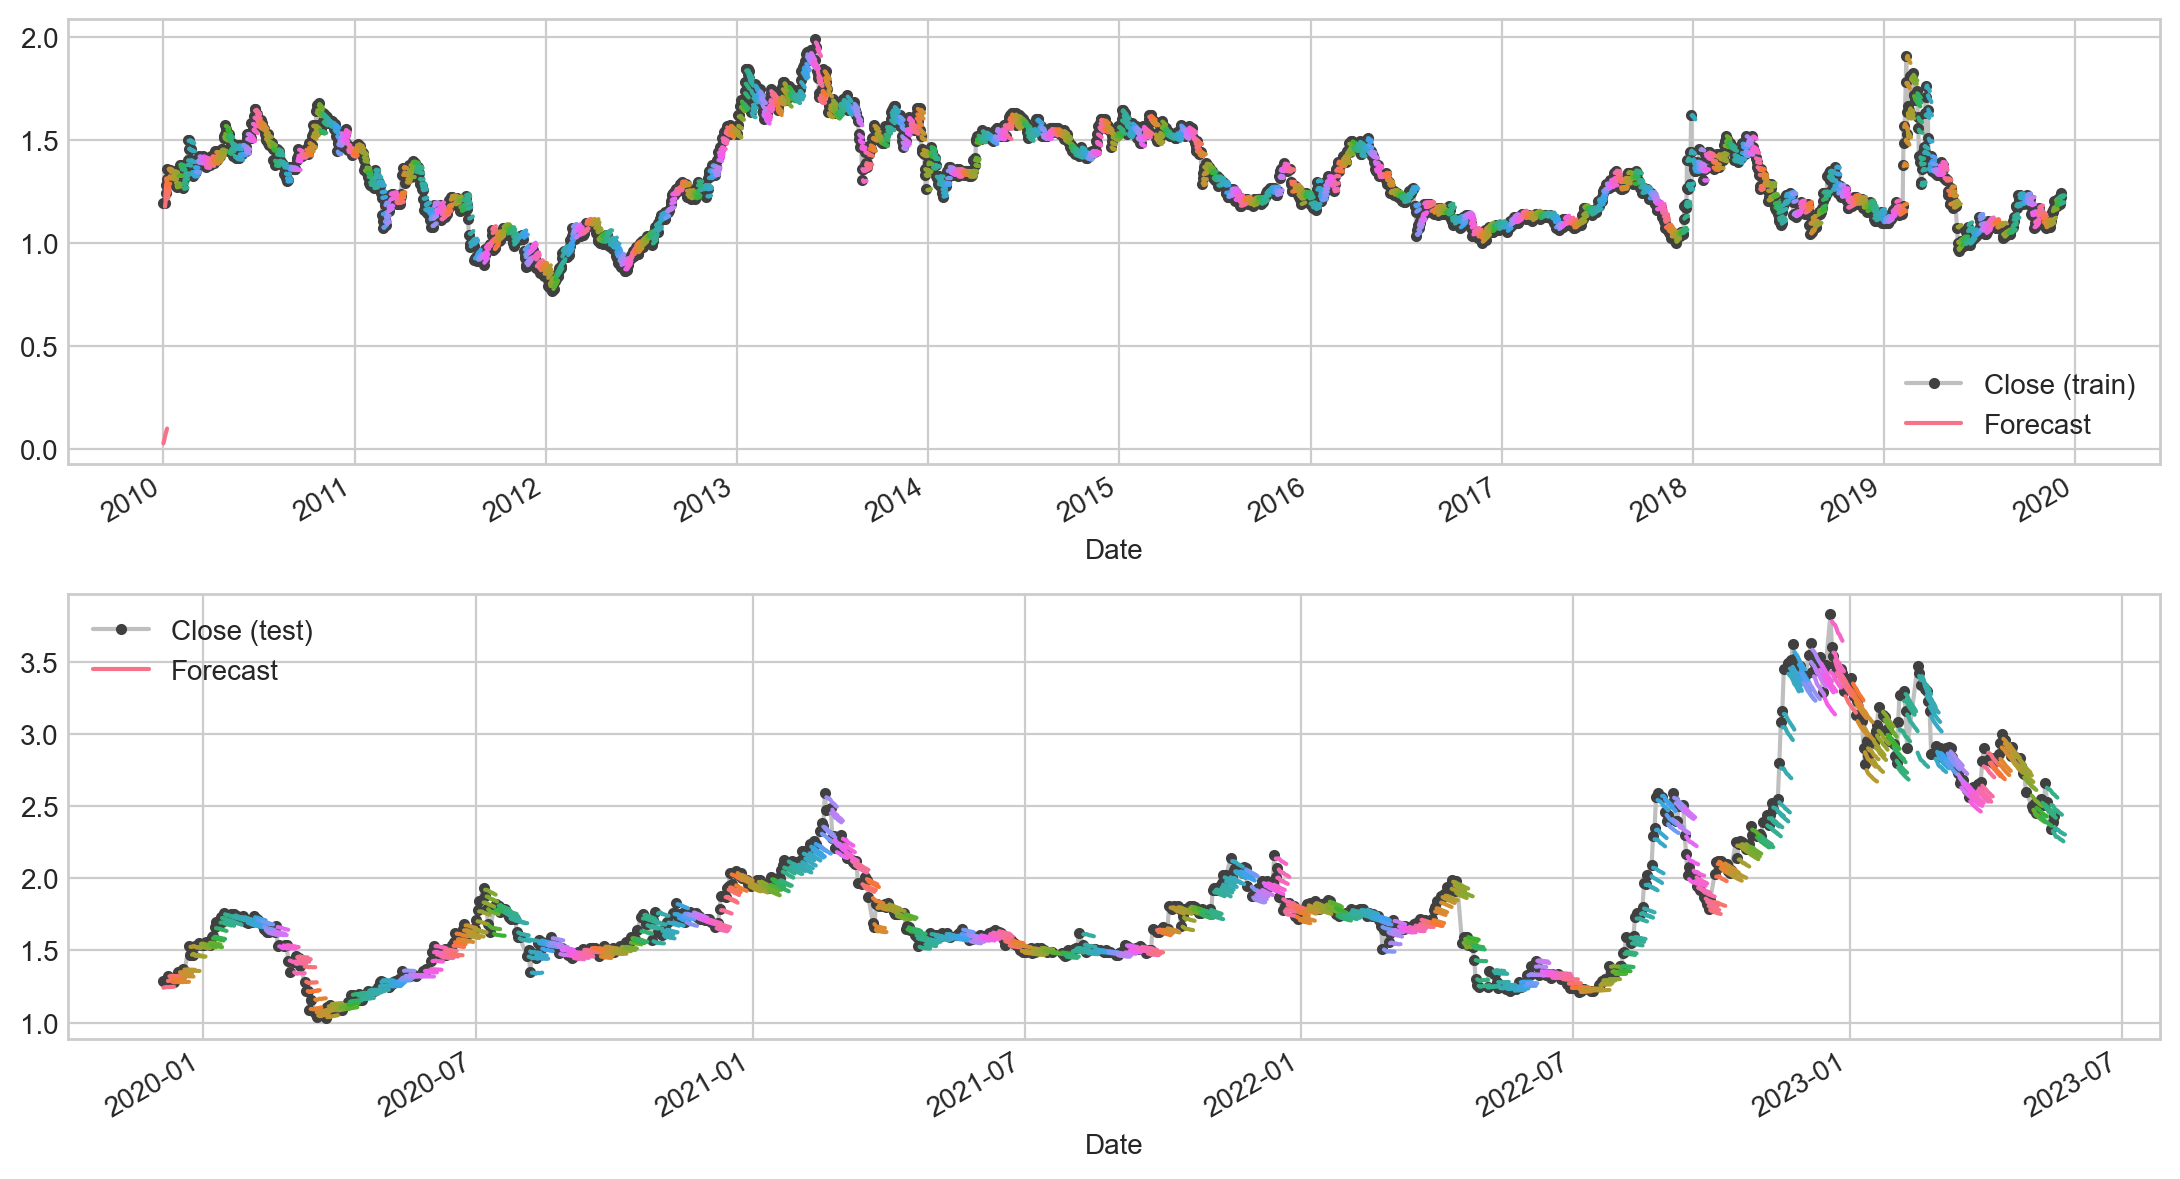

In [16]:
palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = stock.Close[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Close (train)', 'Forecast'])
ax2 = stock.Close[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Close (test)', 'Forecast'])

In [17]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [18]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

Train RMSE: 0.03
Test RMSE: 0.53


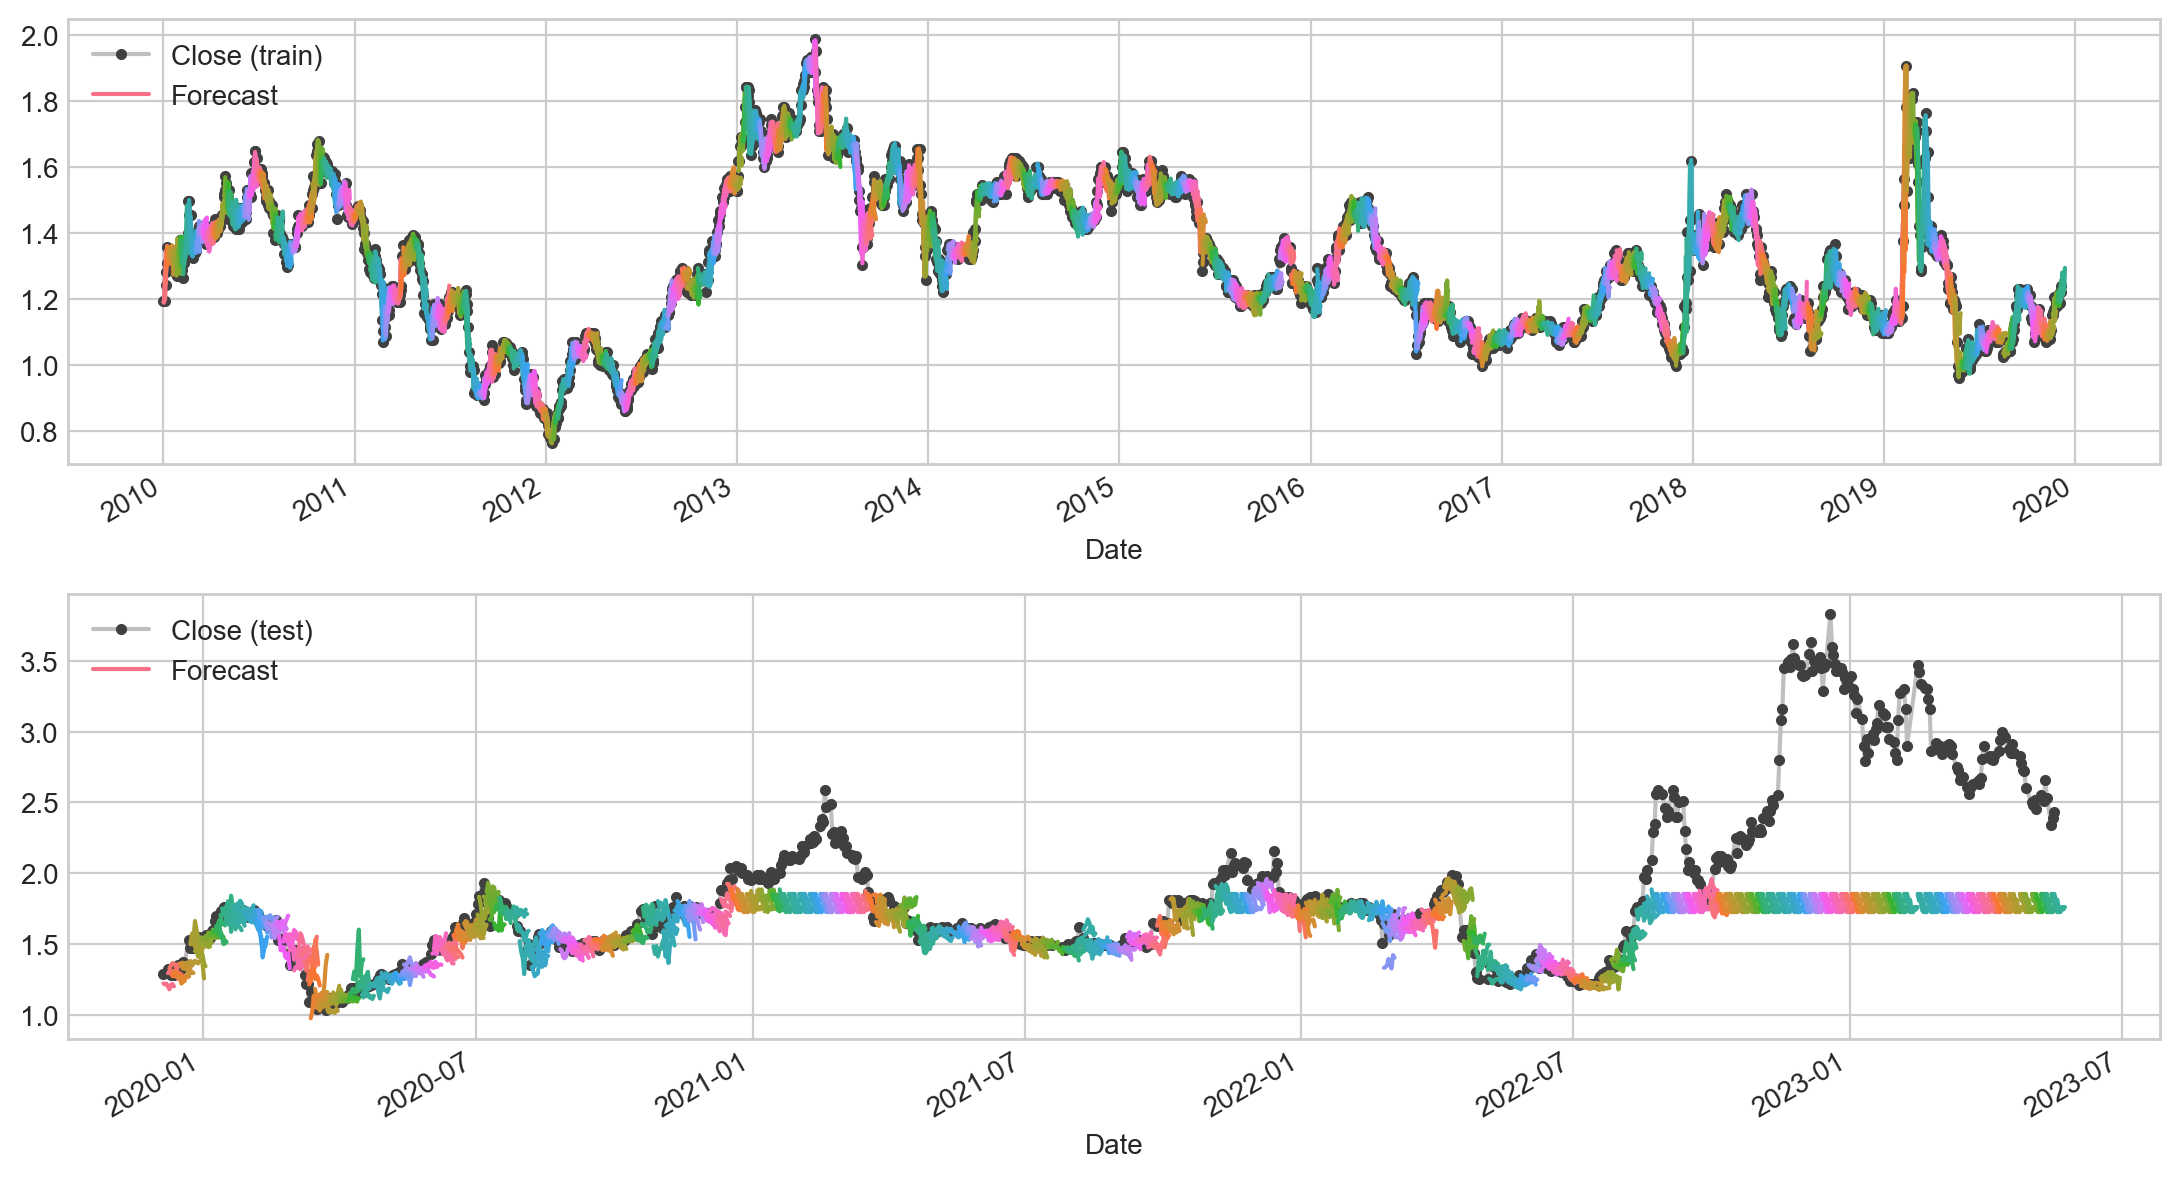

In [19]:
palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = stock.Close[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Close (train)', 'Forecast'])
ax2 = stock.Close[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Close (test)', 'Forecast'])